<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Linking linear diffusion and fluvial incision, using steady state hydrology

Versions of this model are common in the landscape evolution literature. In the model illustrated here, linear diffusion (e.g. Tucker and Bras, 1998, WRR, available <a href="http://onlinelibrary.wiley.com/doi/10.1029/98WR01474/full">here</a>) and detachment-limited incision (e.g. Howard, 1994, WRR, available <a href="http://onlinelibrary.wiley.com/doi/10.1029/94WR00757/full">here</a>) are operating everywhere on the landscape. Process competition leads to convex hillslopes at lower drainage area and concave channels at higher drainage area. Both of the suggested papers have great illustrations of these process interactions.

In this example, some illustrative things to change might be: 
  * hillslope diffusivity 
  * the stream-power coefficient and/or exponents 
  * uplift rate
  * the flow routing method
  * grid size
  * boundary conditions
  * your idea here!

#### Landlab Basics 
To use a Jupyter Notebook to run Landlab, first we import the libraries (code) we need from Landlab, as well as standard plotting functions and numpy.   <br/> 
In Landlab, processes are called components.<br/> 
Every component is a class. <br/> 
The grid is also a class.<br/>  

### Import Landlab and plotting libraries

In [1]:
import pkg_resources

from landlab.plot import imshow_grid
from landlab import RasterModelGrid

from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, PerronNLDiffuse, TaylorNonLinearDiffuser

from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np

C:\Users\berka\AppData\Local\Temp\ipykernel_93124\2331201124.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Set up initial topography
* Instantiate a grid object, here we call it `mg`.

* Set the boundary conditions. In this case the top and bottom edges are fixed value, or open (water and sediment can pass out of the top and bottom boundaries). The right and left edges are closed.

* Make a rough surface as the initial topography.

* Make a plot to see the initial topography.

c:\myapps\Anaconda\envs\shred-ll-env\lib\site-packages\landlab\field\graph_field.py:1347: FutureWarning: Calling `add_empty` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_empty(arg0, at='node').
  data = self.add_empty(*args, **kwds)


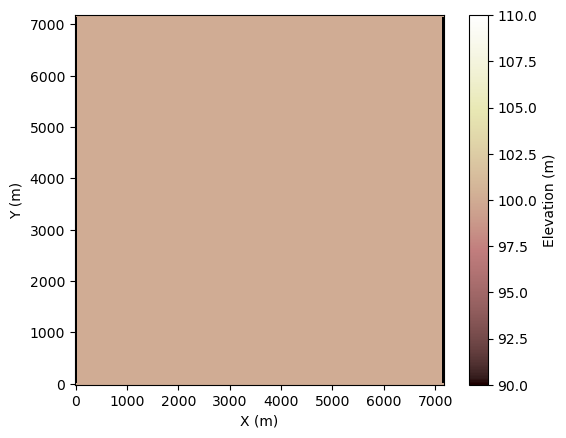

In [2]:
# The grid is 200 rows by 150 columns, with dx = dy = 50 m.
cell_width_length=40
rows=180
colums=180

mg = RasterModelGrid((rows, colums), cell_width_length) 

mg.set_closed_boundaries_at_grid_edges(
    right_is_closed=True,
    top_is_closed=False,
    left_is_closed=True,
    bottom_is_closed=False
)

# Create an initial elevation field with some random perturbations.
z = 100+mg.add_zeros('node', 'topographic__elevation')
initial_roughness = np.random.rand(mg.core_nodes.size)/5
mg.at_node['topographic__elevation'][mg.core_nodes] += initial_roughness

# Plot the elevation field.
imshow_grid(mg, z, grid_units=['m','m'], var_name='Elevation (m)')  

### Initialize time and uplift for the model run.

* Note that units are not imposed by many of the Landlab components, and the grid has no assumed units.

In [3]:
# total_t = 5000000. # this is how long we will run the model for
total_t = 5000000
dt = 1000 # time step in years over which cumulative erosion is calculated and applied to each cell to speed up the model we can use long time scales when hydrology is steady-state in a year. t
nt = int(total_t // dt) # number of time steps

uplift_rate = 0.0004 # uplift rate, this can be a lot hire when landslides are considered
uplift_per_step = uplift_rate * dt # depth (m) of uplift per timestep

Mean_elev=[] # an array to hold the mean elevation of the modeled domain

### Instantiate the process components for this model
In this case the difference components are:
  * `FlowAccumulator` which determines the drainage area at each point. In this case we are using `D8` to determine downslope neighbors.
  * `FastscapeEroder` which calculates the incision rate based on a power-law function of discharge and slope. This uses the Braun and Willet algorithm, reference <a href="http://www.sciencedirect.com/science/article/pii/S0169555X12004618">here</a>)
  * `Diffusers` which calculates erosion and deposition of material using a sediment transport rate which is proportional to the slope. 
  * Note that in the case of `FastscapeEroder`, the values are noted when the class is instantiated. In the case of the `LinearDiffuser`, the value is assigned to a variable and that variable is sent to the class. There are multiple ways to do things, depending on your coding style and what makes sense to you.
  * Remember that the grid was made with an assumed dx in meters. Time values are in years. So any parameters should have units of meters and years.

In [4]:
# Choose diffusivity value and instantiate objects for hillslope diffusion and assign parameter values

# Option 1: LinearDiffuser
k_d = 0.01  # m2/y this is a high-end for this parameter
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=k_d, deposit=True)

# Option 2: Non-linear Diffusion
k_d_nonlin=0.01    # 0.01-0.03   for Oregon like forest, first number with fires second w/o
Sc=1.125           # 1-1.25      for Oregon like forest, first number with fires second w/o
Taylor_nonlin_diffuse = TaylorNonLinearDiffuser(mg, linear_diffusivity=k_d_nonlin, slope_crit=Sc, if_unstable='warn')

# NOTE that if deposit=True, the slope area data will look different.

In [5]:
# Instantiate an object of the FlowAccumulator
fr = FlowAccumulator(mg, flow_director='FlowDirectorD8') 

# Choose parameter values for the stream power (SP) equation
# and instantiate an object of the FastscapeEroder
K_sp=0.00001 # erodibility in SP eqtn, units depend on m_sp (0.00001 for m=0.5) (0.00005 for m=0.25)
m_sp=0.5 # exponent on drainage area in SP eqtn
n_sp=1 # exponent on slope in the SP eqtn

sp = FastscapeEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0)

### Initialize sensor measurement data collection variables
An easy way to store sensor measurements is to organize sensor readings by rows (representing different sensors or locations) and columns (representing times).

In [6]:
# Start with three sensors
sensor_count = 3
time_count = nt

temporal_elevation = np.zeros((sensor_count, time_count))

print(temporal_elevation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


* The calculations are all done in the time loop below.

In [7]:
elevation_snapshots = []
for i in range(nt):
  
    lin_diffuse.run_one_step(dt) # linear diffusion
    fr.run_one_step() # route flow
    sp.run_one_step(dt) # fluvial (SP) incision
    
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    Mean_elev.append(np.mean(mg.at_node['topographic__elevation'][mg.core_nodes]))
    elevation_snapshots.append(mg.at_node['topographic__elevation'][mg.core_nodes])
    
    # Let's choose node 50, 100, and 150 for example
    temporal_elevation[0][i]=mg.at_node['topographic__elevation'][mg.core_nodes][100]
    temporal_elevation[1][i]=mg.at_node['topographic__elevation'][mg.core_nodes][300]
    temporal_elevation[2][i]=mg.at_node['topographic__elevation'][mg.core_nodes][400]
    
    if i % 500 == 0: 
      print ("Completed loop", i, "out of", nt)


Completed loop 0 out of 5000
Completed loop 500 out of 5000
Completed loop 1000 out of 5000
Completed loop 1500 out of 5000
Completed loop 2000 out of 5000
Completed loop 2500 out of 5000
Completed loop 3000 out of 5000
Completed loop 3500 out of 5000
Completed loop 4000 out of 5000
Completed loop 4500 out of 5000


### Visualize the results.
  * First we plot the topography after the time loop.
  * Second we plot the slope-area relationship, which is often used to identify hillslopes, channels, and quantify drainage density.

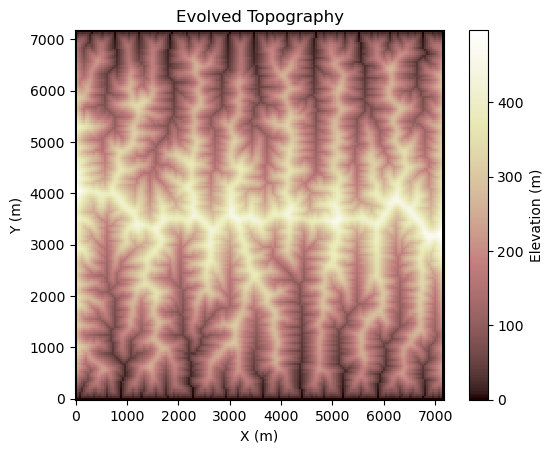

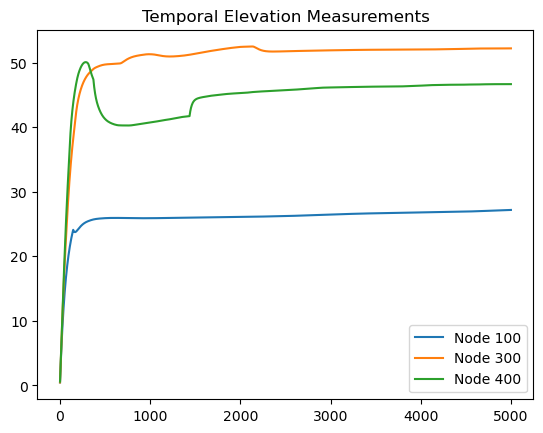

In [8]:
imshow_grid(mg, 'topographic__elevation', grid_units=['m','m'], var_name='Elevation (m)')
plt.title('Evolved Topography')
plt.show()

plt.figure()
plt.title("Temporal Elevation Measurements")
plt.plot(temporal_elevation[0], label='Node 100')
plt.plot(temporal_elevation[1], label='Node 300')
plt.plot(temporal_elevation[2], label='Node 400')
plt.legend()

C:\Users\berka\AppData\Local\Temp\ipykernel_93124\3490570826.py:3: FutureWarning: Calling `add_field` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_field(arg0, arg1, at='node').
  mg.add_field('node','Slope',S, clobber=True)


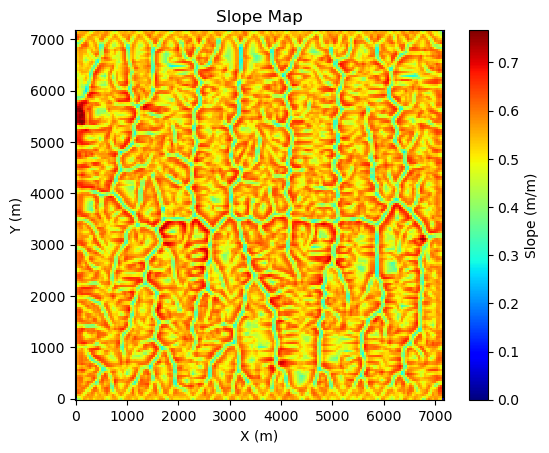

In [9]:
Z=mg.at_node['topographic__elevation']
S = mg.calc_slope_at_node(Z)   # let's call this a slope field and add it to the grid
mg.add_field('node','Slope',S, clobber=True)  

imshow_grid(mg,'Slope', plot_name = 'Slope Map', 
            var_name = 'Slope', var_units = 'm/m', grid_units = ('m','m'),cmap = 'jet')

**Plot of the mean elevation of the landscape**

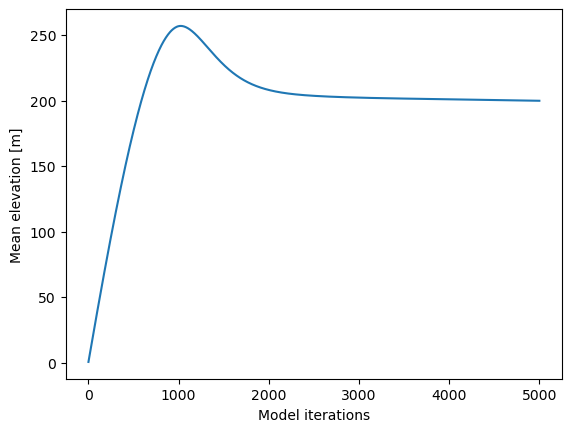

In [10]:
plot(Mean_elev)

plt.xlabel("Model iterations")
plt.ylabel("Mean elevation [m]")

plt.show()

**Plot the mean elevation of the landscape** which can be used to see if landscape dynamic equilibrium (or steady-state)

### plot some channel profiles.

Text(0, 0.5, 'channel slope [m/m]')

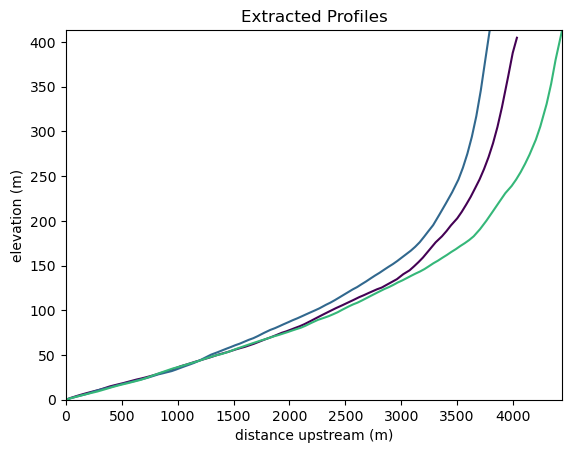

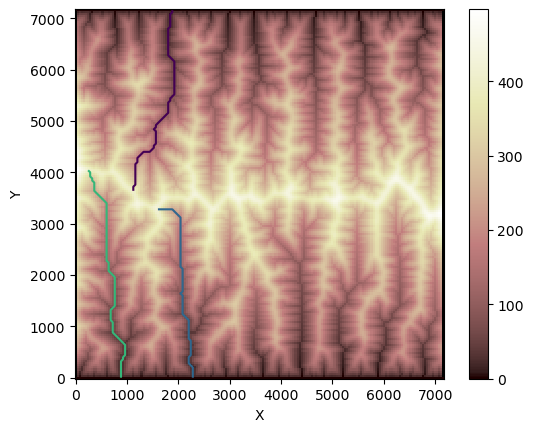

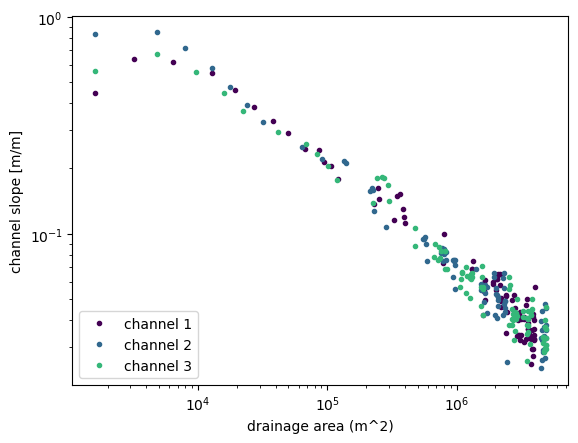

In [11]:
# Import the channel profile tool
from landlab.components import ChannelProfiler

# Instantiate an object of the ChannelProfiler
prf = ChannelProfiler(mg,
                      number_of_watersheds=3,
                      main_channel_only=True,
                      minimum_channel_threshold=1.0) 
prf.run_one_step() # run_one_step just means we are finding the channels

# plot the elevation as a function of distance upstream
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; $K_{{d}}$={k_d}"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view()
#title_text = f"$K_{{sp}}$={K_sp}; $K_{{d}}$={k_d}"
#_ = plt.title(title_text)

# slope-area data in just the profiled channels
plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
#_ = plt.title(title_text)

### Now let's plot channel steepness index and chi

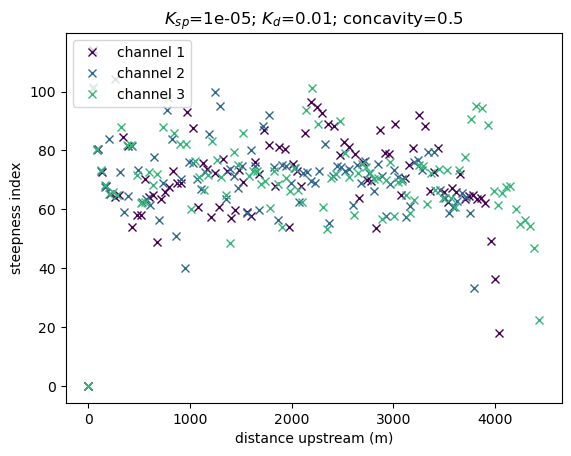

In [12]:
# Import the Landlab Components
from landlab.components import ChiFinder, SteepnessFinder

# calculate reference concavity
theta = m_sp/n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg, reference_concavity=theta, min_drainage_area=1.0)

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(3)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
_ = plt.title(
    f"$K_{{sp}}$={K_sp}; $K_{{d}}$={k_d}; concavity={theta}")

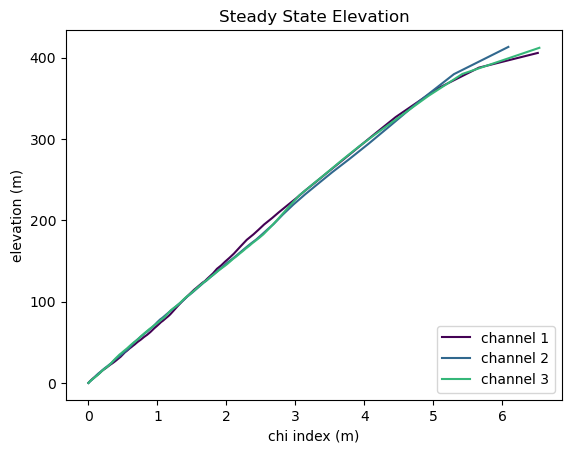

In [13]:
# initialize the component that will calculate the chi index
cf = ChiFinder(mg,
               min_drainage_area=1.0,
               reference_concavity=theta,
               use_true_dx=True)

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(4)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
_ = plt.title("Steady State Elevation")

### Edit the model and rerun it. 
* Remember if you edit any of the code, you need to re-run the edited code block.
* If you re-run the time loop, it will operate on the existing topography. If you want to start over on a flat surface, then you need to re-run the code block that instantiated the grid.

### Using SHRED to reconstruct an elevation map
Using PyShred, DataManager, and the spatio-temporal data we've compiled of elevation evolution, let's try reconstructing an elevation map using just three sensor measurements.

Note that many comments are here for note-taking for the process of learning how to use SHRED

=== PyShred Device Information ===
Current device: cpu
Device config: DeviceConfig(device_type=<DeviceType.AUTO: 'auto'>, device_id=None, force_cpu=False, warn_on_fallback=True)

Device Availability:
  CUDA available: False
  MPS available: False
  CPU: Always available

Sensor Configuration:
     data id  sensor_number                 type  loc/traj
0  ELEVATION              0  stationary (random)  (19985,)
1  ELEVATION              1  stationary (random)  (30581,)
2  ELEVATION              2  stationary (random)  (24469,)

Sensor Measurements:
   ELEVATION-0  ELEVATION-1  ELEVATION-2
0     0.418577     0.528312     0.532795
1     0.820625     0.926905     0.930996
2     1.222511     1.325539     1.329265
3     1.624250     1.724214     1.727596
4     2.025855     2.122928     2.125989

Training SHRED model...
Fitting SHRED...
Epoch 1: Average training loss = 0.054427
Validation MSE (epoch 1): 0.000791
Epoch 2: Average training loss = 0.056971
Validation MSE (epoch 2): 0.000949
Epoch 

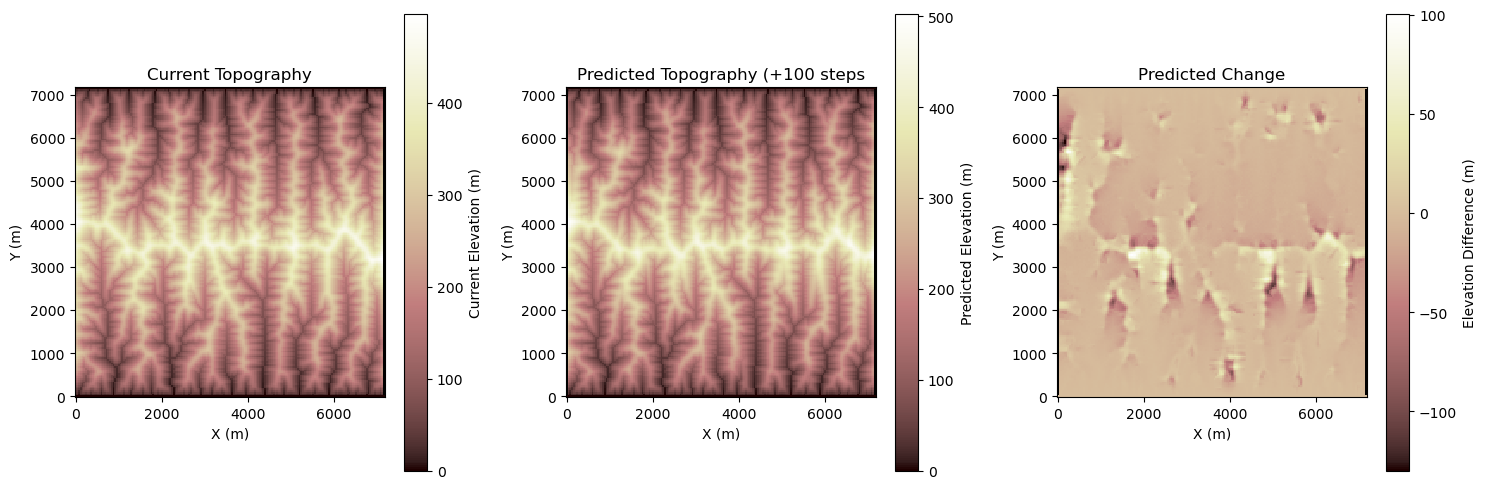

In [14]:
# Import required libraries
import pyshred
from pyshred import DataManager, SHRED, SHREDEngine, SINDy_Forecaster
import torch
import numpy as np
import matplotlib.pyplot as plt

# Setup device
device = pyshred.set_device("auto")
pyshred.device_info()

# Remember that time, or the axis where time is the index and full image is the value, must be 
# at the 0th axis.

# Prepare elevation data for SHRED
# Our temporal_elevation data is already in (sensors, timesteps) format
# We need it in (timesteps, sensors) format for SHRED
elevation_data = temporal_elevation.T

# Initialize Data Manager - we'll use the same amount of timesteps as is in temporal_elevation for lags
manager = DataManager(
    lags=temporal_elevation.shape[0],
    train_size=0.95,   # 95% for training
    val_size=0.025,    # 2.5% for validation
    test_size=0.025    # 2.5% for testing
)

# Add elevation data to the manager
manager.add_data(
    data=torch.tensor(elevation_snapshots),
    id="ELEVATION",
    random=3,
    compress=False
)

# Print information about our sensor setup
print("\nSensor Configuration:")
print(manager.sensor_summary_df)
print("\nSensor Measurements:")
print(manager.sensor_measurements_df.head())

# Prepare datasets
train_dataset, val_dataset, test_dataset = manager.prepare()

# Initialize SHRED with architecture matching our grid dimensions
num_core_nodes = len(mg.core_nodes)

# Figuring out how to use SINDy_Forecaster, LSTM more reliable for now
# SINDy discovers the set of dynamical equations governing the latent space. 
# The number of governing equations discovered will be equal to the size of the latent space. 
# This forecaster is ideal for stable long-term forecasts.
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

# Train the model
print("\nTraining SHRED model...")
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=10
)

# Evaluate model performance
print("\nEvaluating model performance...")
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.6f}")
print(f"Val   MSE: {val_mse:.6f}")
print(f"Test  MSE: {test_mse:.6f}")

# Setup SHRED engine for predictions
print("\nSetting up prediction engine...")
engine = SHREDEngine(manager, shred)

# Get latent space from last known measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)
init_latents = val_latents[-shred.latent_forecaster.seed_length:]

# Predict 100 steps into the future
future_steps = 100
print(f"\nPredicting {future_steps} steps into the future...")
future_latent = engine.forecast_latent(h=future_steps, init_latents=init_latents)

# Decode predictions back to elevation field
future_prediction = engine.decode(future_latent)
print("\nPrediction shape:", future_prediction['ELEVATION'].shape)

# Visualize Results
plt.figure(figsize=(15, 5))

# Current elevation (t = now)
plt.subplot(131)
imshow_grid(mg, 'topographic__elevation', grid_units=['m','m'], 
            var_name='Current Elevation (m)')
plt.title('Current Topography')

# Future elevation (t = now + 10)
plt.subplot(132)
# Get the predicted elevation for the last timestep
final_prediction = future_prediction['ELEVATION']  # Shape: (3,) for 3 sensors

pred_elev = np.zeros(mg.number_of_nodes)  # Initialize full elevation field
pred_elev[mg.core_nodes] = final_prediction[99] # Use first sensor's prediction as example

# Update grid field
mg.at_node['predicted_elevation'] = pred_elev
imshow_grid(mg, 'predicted_elevation', grid_units=['m','m'], 
            var_name='Predicted Elevation (m)')
plt.title(f'Predicted Topography (+{future_steps} steps')

# Difference plot
plt.subplot(133)
diff_elev = mg.at_node['predicted_elevation'] - mg.at_node['topographic__elevation']
mg.at_node['elevation_difference'] = diff_elev
imshow_grid(mg, 'elevation_difference', grid_units=['m','m'], 
            var_name='Elevation Difference (m)')
plt.title('Predicted Change')

plt.tight_layout()
plt.show()